# Classification forecast of kyphosis (individuals wth curved backbones)
target (column 0) - predict whether the person has kyphosis or not

features (column 1 to 3) - the other three parameters for prediction

For the age in column 1, the unit being used is in monthly

In [139]:
# import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [140]:
# Read the first five rows of the csv data file
df = pd.read_csv("M3L5/kyphosis.csv")
df.head()

,Kyphosis,Age,Number,Start
0,absent,71,3,5
1,absent,158,3,14
2,present,128,4,5
3,absent,2,5,1
4,absent,1,4,15


In [141]:
# Look at the quick statitic summary of the data to see if there are anomalies
df.describe()

,Age,Number,Start
count,81.000000,81.000000,81.000000
mean,83.654321,4.049383,11.493827
std,58.104251,1.619423,4.883962
min,1.000000,2.000000,1.000000
25%,26.000000,3.000000,9.000000
50%,87.000000,4.000000,13.000000
75%,130.000000,5.000000,16.000000
max,206.000000,10.000000,18.000000


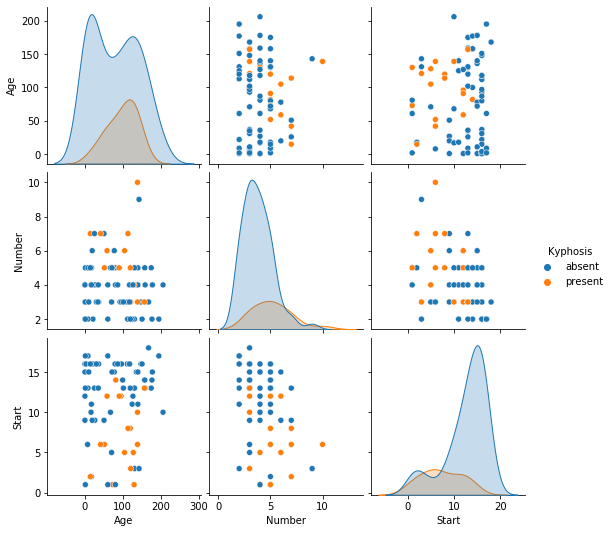

In [142]:
# Plot pairwise relationships in the dataset
# each variable in the data are shared by the same y-axis across a row and x-axis across a column
sns.pairplot(df, hue = 'Kyphosis')

In [143]:
# Change the monthly age to yearly
df["Age"]/=12
df.head()

,Kyphosis,Age,Number,Start
0,absent,5.916667,3,5
1,absent,13.166667,3,14
2,present,10.666667,4,5
3,absent,0.166667,5,1
4,absent,0.083333,4,15


In [144]:
# Get the features and the target
X = df.drop("Kyphosis", axis = 1)
y = df["Kyphosis"]

In [145]:
# summarize the dataset
print(X.shape, y.shape)

(81, 3) (81,)


In [146]:
# spliting into training and testing datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

X_train.head()

,Age,Number,Start
61,9.500000,7,8
73,17.166667,4,10
67,13.250000,4,13
26,0.666667,3,6
79,3.500000,7,6


# 1. AdaBoost

In [147]:
from sklearn.ensemble import AdaBoostClassifier

# instantiate
AdaBoost_model = AdaBoostClassifier(n_estimators=50, random_state=1)

In [148]:
# model training
AdaBoost_model.fit(X_train, y_train)

AdaBoostClassifier(random_state=1)

In [149]:
# model prediction
y_test_pred = AdaBoost_model.predict(X_test)
y_train_pred = AdaBoost_model.predict(X_train)

y_test_pred == y_test

63    True 
27    True 
31    True 
69    True 
46    True 
47    True 
53    True 
76    False
39    False
74    True 
34    True 
62    True 
36    True 
40    False
58    False
10    False
38    False
2     False
35    True 
33    True 
45    False
15    True 
66    True 
56    True 
19    True 
Name: Kyphosis, dtype: bool

In [150]:
# model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### show the confusion matrix
#                                      actual value (absent/present)
# predicted value [[count of true negatives TN, count of false positives FP]
# (absent/present) [count of false negatives FN, count of true positives TP]]
confusion_matrix(y_test, y_test_pred)

array([[17,  2],
       [ 6,  0]], dtype=int64)

In [151]:
# Show the distribution of the testing data
y_test.value_counts(normalize=True)

absent     0.76
present    0.24
Name: Kyphosis, dtype: float64

In [152]:
# Show a classfication report for the test data result
# In this example, absent is the positive and presence is the negative
print(classification_report(y_test,y_test_pred))

# precision - how precise your predictions are (think about prediction as the base) -->  TN/(TN+FN) = 12/(12+6) for absent, TP/(TP+FP) = 2/(2+5) for present
# recall - how complete your predictions are (think about truth as the base) --> TN/(TN+FP) = 12/(12+5) for absent, TP/(TP+FN) = 2/(2+6) for present
# f1 score - harmonic mean of precision and recall --> 2*precision*recall / (precision+recall)
# overfitting - trained model work great in its used data but lack of flexibility when encounter new data

              precision    recall  f1-score   support

      absent       0.74      0.89      0.81        19
     present       0.00      0.00      0.00         6

    accuracy                           0.68        25
   macro avg       0.37      0.45      0.40        25
weighted avg       0.56      0.68      0.62        25



In [153]:
# Show a classfication report for the train data result
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

      absent       1.00      1.00      1.00        45
     present       1.00      1.00      1.00        11

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56



In [154]:
# Show the feature importance
AdaBoost_model.feature_importances_

array([0.76, 0.14, 0.1 ])

Train score: 1.0
Test score: 0.68

Train confusion matrix


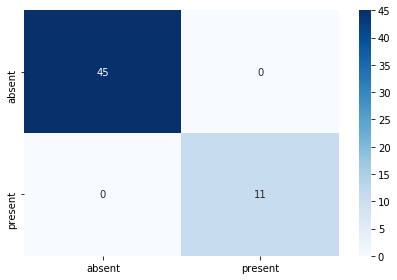


Test confusion matrix


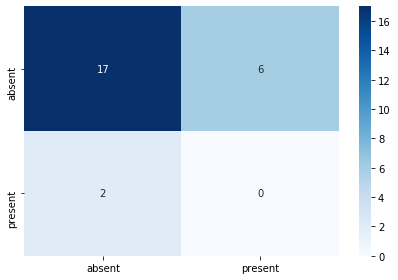

In [155]:
# function to plot a more fansy confusion matrix
classes = ['absent','present']

def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'\n{dom} confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()
    
print(f'Train score: {accuracy_score(y_train_pred,y_train)}')
print(f'Test score: {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

In [156]:
# Hyperparamter tuning by Optuna
import time
import sklearn
import optuna
from sklearn.tree import DecisionTreeClassifier

# define the machine learning logic and return the evaluation score here  
def AdaBoost_objective(trial):

#     df = pd.read_csv("M3L5/kyphosis.csv")
#     df["Age"]/=12
#     X = df.drop("Kyphosis", axis = 1)
#     y = df["Kyphosis"]
#     X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

    classifier_name = trial.suggest_categorical("classifier", ["AdaBoost"])
    if classifier_name == "AdaBoost":
        # The suggested parameter for tuning
        AdaBoost_n_estimators = trial.suggest_int("AdaBoost_n_estimators", 1, 200, step = 1)
        AdaBoost_max_depth = trial.suggest_int("AdaBoost_max_depth", 1, 5, step = 1)
        AdaBoost_learning_rate = trial.suggest_categorical("AdaBoost_learning_rate", [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2])
        # rf_oob_score = trial.suggest_categorical("rf_oob_score", [True, False])
        classifier_obj = sklearn.ensemble.AdaBoostClassifier(
            n_estimators = AdaBoost_n_estimators, 
            base_estimator = DecisionTreeClassifier(max_depth=AdaBoost_max_depth),
            learning_rate = AdaBoost_learning_rate,
            # oob_score = rf_oob_score,
            random_state=1
        )

    score = sklearn.model_selection.cross_val_score(classifier_obj, X_test, y_test, n_jobs=-1, cv=4)
    accuracy = score.mean()
    return accuracy

start = time.time()
if __name__ == "__main__":
    # Create Study object
    AdaBoost_study = optuna.create_study(direction="maximize")
    # Optimize the study, use more trials to obtain better result, use less trials to be more cost-efficient
    AdaBoost_study.optimize(AdaBoost_objective, n_trials=100)
    # Print the result
    print(f"Best score: {AdaBoost_study.best_value:0.4f}\n") # Return the best objective value in the study
    print(f"Optimized parameters: {AdaBoost_study.best_params}\n")
    print(f"Best trial: {AdaBoost_study.best_trial}\n")
end = time.time()
AdaBoost_time = end-start
print(f"Elapsed time: {AdaBoost_time:0.2f} seconds")

[I 2022-03-29 17:22:55,580] A new study created in memory with name: no-name-7d9b4a6c-04b2-4bc0-b9ca-96c6320f1946
[I 2022-03-29 17:23:02,277] Trial 0 finished with value: 0.5535714285714286 and parameters: {'classifier': 'AdaBoost', 'AdaBoost_n_estimators': 187, 'AdaBoost_max_depth': 2, 'AdaBoost_learning_rate': 0.5}. Best is trial 0 with value: 0.5535714285714286.
[I 2022-03-29 17:23:02,373] Trial 1 finished with value: 0.6369047619047619 and parameters: {'classifier': 'AdaBoost', 'AdaBoost_n_estimators': 4, 'AdaBoost_max_depth': 4, 'AdaBoost_learning_rate': 0.5}. Best is trial 1 with value: 0.6369047619047619.
[I 2022-03-29 17:23:02,557] Trial 2 finished with value: 0.6428571428571429 and parameters: {'classifier': 'AdaBoost', 'AdaBoost_n_estimators': 146, 'AdaBoost_max_depth': 3, 'AdaBoost_learning_rate': 2}. Best is trial 2 with value: 0.6428571428571429.
[I 2022-03-29 17:23:03,065] Trial 3 finished with value: 0.636904761904762 and parameters: {'classifier': 'AdaBoost', 'AdaBoost_

[I 2022-03-29 17:23:11,528] Trial 31 finished with value: 0.6785714285714286 and parameters: {'classifier': 'AdaBoost', 'AdaBoost_n_estimators': 69, 'AdaBoost_max_depth': 4, 'AdaBoost_learning_rate': 0.0001}. Best is trial 4 with value: 0.6785714285714286.
[I 2022-03-29 17:23:11,792] Trial 32 finished with value: 0.6785714285714286 and parameters: {'classifier': 'AdaBoost', 'AdaBoost_n_estimators': 73, 'AdaBoost_max_depth': 4, 'AdaBoost_learning_rate': 0.0001}. Best is trial 4 with value: 0.6785714285714286.
[I 2022-03-29 17:23:12,088] Trial 33 finished with value: 0.6785714285714286 and parameters: {'classifier': 'AdaBoost', 'AdaBoost_n_estimators': 89, 'AdaBoost_max_depth': 4, 'AdaBoost_learning_rate': 0.0001}. Best is trial 4 with value: 0.6785714285714286.
[I 2022-03-29 17:23:12,168] Trial 34 finished with value: 0.6369047619047619 and parameters: {'classifier': 'AdaBoost', 'AdaBoost_n_estimators': 98, 'AdaBoost_max_depth': 4, 'AdaBoost_learning_rate': 0.5}. Best is trial 4 with va

[I 2022-03-29 17:23:18,954] Trial 62 finished with value: 0.6785714285714286 and parameters: {'classifier': 'AdaBoost', 'AdaBoost_n_estimators': 103, 'AdaBoost_max_depth': 4, 'AdaBoost_learning_rate': 0.0001}. Best is trial 4 with value: 0.6785714285714286.
[I 2022-03-29 17:23:19,219] Trial 63 finished with value: 0.6785714285714286 and parameters: {'classifier': 'AdaBoost', 'AdaBoost_n_estimators': 85, 'AdaBoost_max_depth': 4, 'AdaBoost_learning_rate': 0.0001}. Best is trial 4 with value: 0.6785714285714286.
[I 2022-03-29 17:23:19,434] Trial 64 finished with value: 0.6785714285714286 and parameters: {'classifier': 'AdaBoost', 'AdaBoost_n_estimators': 58, 'AdaBoost_max_depth': 4, 'AdaBoost_learning_rate': 0.0001}. Best is trial 4 with value: 0.6785714285714286.
[I 2022-03-29 17:23:19,713] Trial 65 finished with value: 0.6785714285714286 and parameters: {'classifier': 'AdaBoost', 'AdaBoost_n_estimators': 85, 'AdaBoost_max_depth': 4, 'AdaBoost_learning_rate': 0.0001}. Best is trial 4 wit

[I 2022-03-29 17:23:27,050] Trial 93 finished with value: 0.6785714285714286 and parameters: {'classifier': 'AdaBoost', 'AdaBoost_n_estimators': 35, 'AdaBoost_max_depth': 4, 'AdaBoost_learning_rate': 0.0001}. Best is trial 4 with value: 0.6785714285714286.
[I 2022-03-29 17:23:27,190] Trial 94 finished with value: 0.6785714285714286 and parameters: {'classifier': 'AdaBoost', 'AdaBoost_n_estimators': 33, 'AdaBoost_max_depth': 4, 'AdaBoost_learning_rate': 0.0001}. Best is trial 4 with value: 0.6785714285714286.
[I 2022-03-29 17:23:27,318] Trial 95 finished with value: 0.6785714285714286 and parameters: {'classifier': 'AdaBoost', 'AdaBoost_n_estimators': 27, 'AdaBoost_max_depth': 4, 'AdaBoost_learning_rate': 0.0001}. Best is trial 4 with value: 0.6785714285714286.
[I 2022-03-29 17:23:27,386] Trial 96 finished with value: 0.6369047619047619 and parameters: {'classifier': 'AdaBoost', 'AdaBoost_n_estimators': 28, 'AdaBoost_max_depth': 4, 'AdaBoost_learning_rate': 0.1}. Best is trial 4 with va

Best score: 0.6786

Optimized parameters: {'classifier': 'AdaBoost', 'AdaBoost_n_estimators': 21, 'AdaBoost_max_depth': 4, 'AdaBoost_learning_rate': 0.0001}

Best trial: FrozenTrial(number=4, values=[0.6785714285714286], datetime_start=datetime.datetime(2022, 3, 29, 17, 23, 3, 69073), datetime_complete=datetime.datetime(2022, 3, 29, 17, 23, 3, 230066), params={'classifier': 'AdaBoost', 'AdaBoost_n_estimators': 21, 'AdaBoost_max_depth': 4, 'AdaBoost_learning_rate': 0.0001}, distributions={'classifier': CategoricalDistribution(choices=('AdaBoost',)), 'AdaBoost_n_estimators': IntUniformDistribution(high=200, low=1, step=1), 'AdaBoost_max_depth': IntUniformDistribution(high=5, low=1, step=1), 'AdaBoost_learning_rate': CategoricalDistribution(choices=(0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=4, state=TrialState.COMPLETE, value=None)

Elapsed time: 32.22 seconds


In [157]:
# Define a function which stores the params with the same best scores after hyperparameter tuning by Optuna
def best_result_df(study):
    best_params = []
    best_values = []
    for i in range(0,len(study.trials)):
        if study.trials[i].value == study.best_value:
            best_values.append(study.best_value)
            best_params.append(study.trials[i].params)

    return best_params

In [158]:
# store all the params if they receive the same score as that of the best score
AdaBoost_best_params = best_result_df(AdaBoost_study)
AdaBoost_best_params

[{'classifier': 'AdaBoost',
  'AdaBoost_n_estimators': 21,
  'AdaBoost_max_depth': 4,
  'AdaBoost_learning_rate': 0.0001},
 {'classifier': 'AdaBoost',
  'AdaBoost_n_estimators': 22,
  'AdaBoost_max_depth': 4,
  'AdaBoost_learning_rate': 0.0001},
 {'classifier': 'AdaBoost',
  'AdaBoost_n_estimators': 64,
  'AdaBoost_max_depth': 4,
  'AdaBoost_learning_rate': 0.0001},
 {'classifier': 'AdaBoost',
  'AdaBoost_n_estimators': 74,
  'AdaBoost_max_depth': 4,
  'AdaBoost_learning_rate': 0.0001},
 {'classifier': 'AdaBoost',
  'AdaBoost_n_estimators': 66,
  'AdaBoost_max_depth': 4,
  'AdaBoost_learning_rate': 0.0001},
 {'classifier': 'AdaBoost',
  'AdaBoost_n_estimators': 69,
  'AdaBoost_max_depth': 4,
  'AdaBoost_learning_rate': 0.0001},
 {'classifier': 'AdaBoost',
  'AdaBoost_n_estimators': 73,
  'AdaBoost_max_depth': 4,
  'AdaBoost_learning_rate': 0.0001},
 {'classifier': 'AdaBoost',
  'AdaBoost_n_estimators': 89,
  'AdaBoost_max_depth': 4,
  'AdaBoost_learning_rate': 0.0001},
 {'classifier': 

### The tuned AdaBoost model give the same test data model accuracy as 68% as before tuning.

In [159]:
pd.set_option('display.max_colwidth', -1)
performance_df = pd.DataFrame({'AdaBoost':[np.round(AdaBoost_study.best_value,4), AdaBoost_study.best_params, np.round(AdaBoost_time,2), "n_estimators, base_estimator, learning_rate", len(AdaBoost_best_params)]}, index=['Best score', 'Optimized parameter', 'Computed time', 'Hyperparameters', 'No. of Optimized Params giving the Best score'])
performance_df
# Indeed, if take a look back to the results from Optuna, there are many combinations giving the same result as the optimized paramters
# output the same results as the optimzed parameter. 

,AdaBoost
Best score,0.6786
Optimized parameter,"{'classifier': 'AdaBoost', 'AdaBoost_n_estimators': 21, 'AdaBoost_max_depth': 4, 'AdaBoost_learning_rate': 0.0001}"
Computed time,32.22
Hyperparameters,"n_estimators, base_estimator, learning_rate"
No. of Optimized Params giving the Best score,43


# 2. Gradient Boost

      Iter       Train Loss   Remaining Time 
         1           0.8674            0.20s
         2           0.7605            0.20s
         3           0.6916            0.19s
         4           0.6246            0.22s
         5           0.5754            0.23s
         6           0.5292            0.23s
         7           0.4872            0.23s
         8           0.4527            0.22s
         9           0.4203            0.21s
        10           0.3926            0.22s
        20           0.2266            0.15s
        30           0.1387            0.16s
        40           0.0863            0.13s
        50           0.0558            0.10s
        60           0.0363            0.08s
        70           0.0246            0.06s
        80           0.0173            0.04s
        90           0.0118            0.02s
       100           0.0078            0.00s
The confusion matrix for testing data: 
[[17  2]
 [ 5  1]]

The classification report for testing d

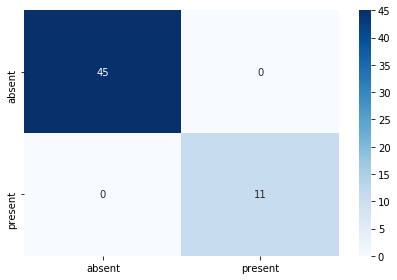


Test confusion matrix


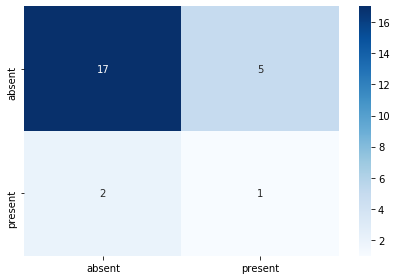

In [160]:
from sklearn.ensemble import GradientBoostingClassifier

### instantiate
GradientBoost_model = GradientBoostingClassifier(random_state=1, verbose = 1) # Default: validation_fraction = 0.1

### model training
GradientBoost_model.fit(X_train, y_train)

### model prediction
y_test_pred = GradientBoost_model.predict(X_test)
y_train_pred = GradientBoost_model.predict(X_train)

### model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# show the confusion matrix
print(f'The confusion matrix for testing data: \n{confusion_matrix(y_test, y_test_pred)}')
# Show a classfication report for the test data result
# In this example, absent is the positive and presence is the negative
print(f'\nThe classification report for testing data: \n{classification_report(y_test,y_test_pred)}')

# Show a classfication report for the train data result
print(f'\nThe classification report for training data: \n{classification_report(y_train,y_train_pred)}')

# Show the feature importance
print(f'\nThe feature importance: {GradientBoost_model.feature_importances_}')
      
# function to plot a fansier confusion matrix
classes = ['absent','present']
def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'\n{dom} confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
                ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()
    
print(f'\nTrain score: {accuracy_score(y_train_pred,y_train)}')
print(f'Test score: {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

In [161]:
# Hyperparamter tuning by Optuna
import time
import sklearn
import optuna

# define the machine learning logic and return the evaluation score here  
def GradientBoost_objective(trial):

#     df = pd.read_csv("M3L5/kyphosis.csv")
#     df["Age"]/=12
#     X = df.drop("Kyphosis", axis = 1)
#     y = df["Kyphosis"]
#     X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

    classifier_name = trial.suggest_categorical("classifier", ["GradientBoost"])
    if classifier_name == "GradientBoost":
        # The suggested parameter for tuning
        GradientBoost_n_estimators = trial.suggest_int("GradientBoost_n_estimators", 1, 200, step = 1)
        GradientBoost_learning_rate = trial.suggest_categorical("GradientBoost_learning_rate", [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2])
        GradientBoost_max_features = trial.suggest_categorical("GradientBoost_max_features", [None, 'sqrt', 'log2'])
        GradientBoost_max_depth = trial.suggest_int("GradientBoost_max_depth", 1, 6, step = 1)
                # rf_oob_score = trial.suggest_categorical("rf_oob_score", [True, False])
        classifier_obj = sklearn.ensemble.GradientBoostingClassifier(
            n_estimators = GradientBoost_n_estimators, 
            learning_rate = GradientBoost_learning_rate,
            max_features = GradientBoost_max_features,
            max_depth = GradientBoost_max_depth,
            # oob_score = rf_oob_score,
            random_state=1
        )

    score = sklearn.model_selection.cross_val_score(classifier_obj, X_test, y_test, n_jobs=-1, cv=4)
    accuracy = score.mean()
    return accuracy

start = time.time()
if __name__ == "__main__":
    # Create Study object
    GradientBoost_study = optuna.create_study(direction="maximize")
    # Optimize the study, use more trials to obtain better result, use less trials to be more cost-efficient
    GradientBoost_study.optimize(GradientBoost_objective, n_trials=100)
    # Print the result
    print(f"Best score: {GradientBoost_study.best_value:0.4f}\n") # Return the best objective value in the study
    print(f"Optimized parameters: {GradientBoost_study.best_params}\n")
    print(f"Best trial: {GradientBoost_study.best_trial}\n")
end = time.time()
GradientBoost_time = end-start
print(f"Elapsed time: {GradientBoost_time:0.2f} seconds")

[I 2022-03-29 17:23:32,947] A new study created in memory with name: no-name-6aa9e63f-407e-4e34-83d3-acab4e1a919b
[I 2022-03-29 17:23:33,121] Trial 0 finished with value: 0.7619047619047619 and parameters: {'classifier': 'GradientBoost', 'GradientBoost_n_estimators': 56, 'GradientBoost_learning_rate': 0.0001, 'GradientBoost_max_features': 'sqrt', 'GradientBoost_max_depth': 2}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-29 17:23:33,500] Trial 1 finished with value: 0.5952380952380952 and parameters: {'classifier': 'GradientBoost', 'GradientBoost_n_estimators': 170, 'GradientBoost_learning_rate': 0.1, 'GradientBoost_max_features': None, 'GradientBoost_max_depth': 4}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-29 17:23:33,692] Trial 2 finished with value: 0.7619047619047619 and parameters: {'classifier': 'GradientBoost', 'GradientBoost_n_estimators': 86, 'GradientBoost_learning_rate': 0.001, 'GradientBoost_max_features': 'sqrt', 'GradientBoost_max_depth': 2

[I 2022-03-29 17:23:38,366] Trial 25 finished with value: 0.7619047619047619 and parameters: {'classifier': 'GradientBoost', 'GradientBoost_n_estimators': 41, 'GradientBoost_learning_rate': 0.0001, 'GradientBoost_max_features': None, 'GradientBoost_max_depth': 3}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-29 17:23:38,497] Trial 26 finished with value: 0.7619047619047619 and parameters: {'classifier': 'GradientBoost', 'GradientBoost_n_estimators': 51, 'GradientBoost_learning_rate': 0.01, 'GradientBoost_max_features': None, 'GradientBoost_max_depth': 1}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-29 17:23:38,598] Trial 27 finished with value: 0.7619047619047619 and parameters: {'classifier': 'GradientBoost', 'GradientBoost_n_estimators': 16, 'GradientBoost_learning_rate': 0.0001, 'GradientBoost_max_features': None, 'GradientBoost_max_depth': 5}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-29 17:23:38,715] Trial 28 finished with value: 0.761

[I 2022-03-29 17:23:42,591] Trial 51 finished with value: 0.7619047619047619 and parameters: {'classifier': 'GradientBoost', 'GradientBoost_n_estimators': 25, 'GradientBoost_learning_rate': 0.01, 'GradientBoost_max_features': None, 'GradientBoost_max_depth': 2}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-29 17:23:42,763] Trial 52 finished with value: 0.7619047619047619 and parameters: {'classifier': 'GradientBoost', 'GradientBoost_n_estimators': 95, 'GradientBoost_learning_rate': 0.01, 'GradientBoost_max_features': None, 'GradientBoost_max_depth': 1}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-29 17:23:42,869] Trial 53 finished with value: 0.6369047619047619 and parameters: {'classifier': 'GradientBoost', 'GradientBoost_n_estimators': 28, 'GradientBoost_learning_rate': 2, 'GradientBoost_max_features': None, 'GradientBoost_max_depth': 2}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-29 17:23:43,059] Trial 54 finished with value: 0.6369047619

[I 2022-03-29 17:23:48,309] Trial 77 finished with value: 0.7619047619047619 and parameters: {'classifier': 'GradientBoost', 'GradientBoost_n_estimators': 64, 'GradientBoost_learning_rate': 0.001, 'GradientBoost_max_features': None, 'GradientBoost_max_depth': 3}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-29 17:23:48,446] Trial 78 finished with value: 0.7619047619047619 and parameters: {'classifier': 'GradientBoost', 'GradientBoost_n_estimators': 56, 'GradientBoost_learning_rate': 0.001, 'GradientBoost_max_features': None, 'GradientBoost_max_depth': 2}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-29 17:23:48,593] Trial 79 finished with value: 0.6785714285714286 and parameters: {'classifier': 'GradientBoost', 'GradientBoost_n_estimators': 66, 'GradientBoost_learning_rate': 0.5, 'GradientBoost_max_features': None, 'GradientBoost_max_depth': 3}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-29 17:23:48,722] Trial 80 finished with value: 0.595238

Best score: 0.7619

Optimized parameters: {'classifier': 'GradientBoost', 'GradientBoost_n_estimators': 56, 'GradientBoost_learning_rate': 0.0001, 'GradientBoost_max_features': 'sqrt', 'GradientBoost_max_depth': 2}

Best trial: FrozenTrial(number=0, values=[0.7619047619047619], datetime_start=datetime.datetime(2022, 3, 29, 17, 23, 32, 955827), datetime_complete=datetime.datetime(2022, 3, 29, 17, 23, 33, 120501), params={'classifier': 'GradientBoost', 'GradientBoost_n_estimators': 56, 'GradientBoost_learning_rate': 0.0001, 'GradientBoost_max_features': 'sqrt', 'GradientBoost_max_depth': 2}, distributions={'classifier': CategoricalDistribution(choices=('GradientBoost',)), 'GradientBoost_n_estimators': IntUniformDistribution(high=200, low=1, step=1), 'GradientBoost_learning_rate': CategoricalDistribution(choices=(0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2)), 'GradientBoost_max_features': CategoricalDistribution(choices=(None, 'sqrt', 'log2')), 'GradientBoost_max_depth': IntUniformDistribution(hi

In [162]:
# store all the params if they receive the same score as that of the best score
GradientBoost_best_params = best_result_df(GradientBoost_study)
for i in GradientBoost_best_params:
    print(i.values())
print(f'The total number of hyperparameter combinations output the best value: {len(GradientBoost_best_params)}')

dict_values(['GradientBoost', 56, 0.0001, 'sqrt', 2])
dict_values(['GradientBoost', 86, 0.001, 'sqrt', 2])
dict_values(['GradientBoost', 116, 0.001, None, 1])
dict_values(['GradientBoost', 170, 0.001, 'sqrt', 1])
dict_values(['GradientBoost', 73, 0.0001, 'sqrt', 5])
dict_values(['GradientBoost', 169, 0.0001, 'log2', 4])
dict_values(['GradientBoost', 100, 0.001, None, 2])
dict_values(['GradientBoost', 26, 0.0001, None, 2])
dict_values(['GradientBoost', 122, 0.01, None, 1])
dict_values(['GradientBoost', 21, 0.0001, None, 2])
dict_values(['GradientBoost', 123, 0.01, None, 1])
dict_values(['GradientBoost', 7, 0.0001, None, 3])
dict_values(['GradientBoost', 42, 0.0001, None, 1])
dict_values(['GradientBoost', 53, 0.01, None, 1])
dict_values(['GradientBoost', 4, 0.0001, None, 3])
dict_values(['GradientBoost', 41, 0.0001, None, 3])
dict_values(['GradientBoost', 51, 0.01, None, 1])
dict_values(['GradientBoost', 16, 0.0001, None, 5])
dict_values(['GradientBoost', 32, 0.0001, None, 3])
dict_value

### The tuned Gradient Boost model improves the test data model accuracy from 72% to 76%.

In [163]:
performance_df['Gradient Boost'] = [round(GradientBoost_study.best_value,4), GradientBoost_study.best_params, np.round(GradientBoost_time,2), "n_estimators, learning_rate, max_features, max_depth", len(GradientBoost_best_params)]
performance_df

,AdaBoost,Gradient Boost
Best score,0.6786,0.7619
Optimized parameter,"{'classifier': 'AdaBoost', 'AdaBoost_n_estimators': 21, 'AdaBoost_max_depth': 4, 'AdaBoost_learning_rate': 0.0001}","{'classifier': 'GradientBoost', 'GradientBoost_n_estimators': 56, 'GradientBoost_learning_rate': 0.0001, 'GradientBoost_max_features': 'sqrt', 'GradientBoost_max_depth': 2}"
Computed time,32.22,20.93
Hyperparameters,"n_estimators, base_estimator, learning_rate","n_estimators, learning_rate, max_features, max_depth"
No. of Optimized Params giving the Best score,43,74


# 3. XGBoost

In [194]:
from xgboost import XGBClassifier
# instantiate
XGBoost_model = XGBClassifier(random_state = 1, verbosity = 1)

# model training
XGBoost_model.fit(X_train, y_train)

[14:20:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

The confusion matrix for testing data: 
[[17  2]
 [ 5  1]]

The classification report for testing data: 
              precision    recall  f1-score   support

      absent       0.77      0.89      0.83        19
     present       0.33      0.17      0.22         6

    accuracy                           0.72        25
   macro avg       0.55      0.53      0.53        25
weighted avg       0.67      0.72      0.68        25


The classification report for training data: 
              precision    recall  f1-score   support

      absent       0.98      1.00      0.99        45
     present       1.00      0.91      0.95        11

    accuracy                           0.98        56
   macro avg       0.99      0.95      0.97        56
weighted avg       0.98      0.98      0.98        56


The feature importance: [0.13468432 0.4150557  0.45026004]

Train score: 0.9821428571428571
Test score: 0.72

Train confusion matrix


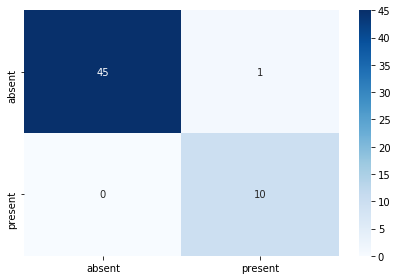


Test confusion matrix


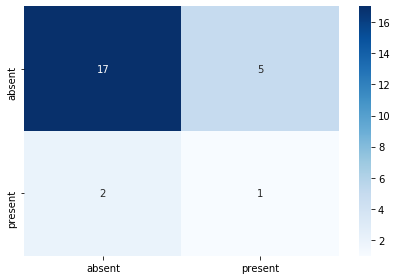

In [195]:
### model prediction
y_test_pred = XGBoost_model.predict(X_test)
y_train_pred = XGBoost_model.predict(X_train)

### model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# show the confusion matrix
print(f'The confusion matrix for testing data: \n{confusion_matrix(y_test, y_test_pred)}')
# Show a classfication report for the test data result
# In this example, absent is the positive and presence is the negative
print(f'\nThe classification report for testing data: \n{classification_report(y_test,y_test_pred)}')

# Show a classfication report for the train data result
print(f'\nThe classification report for training data: \n{classification_report(y_train,y_train_pred)}')

# Show the feature importance
print(f'\nThe feature importance: {XGBoost_model.feature_importances_}')
      
# function to plot a fansier confusion matrix
classes = ['absent','present']
def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'\n{dom} confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
                ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()
    
print(f'\nTrain score: {accuracy_score(y_train_pred,y_train)}')
print(f'Test score: {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

In [196]:
# Hyperparamter tuning by Optuna
import time
import sklearn
import optuna

# define the machine learning logic and return the evaluation score here  
def XGBoost_objective(trial):

#     df = pd.read_csv("M3L5/kyphosis.csv")
#     df["Age"]/=12
#     X = df.drop("Kyphosis", axis = 1)
#     y = df["Kyphosis"]
#     X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

    classifier_name = trial.suggest_categorical("classifier", ["XGBoost"])
    if classifier_name == "XGBoost":
        # The suggested parameter for tuning
        XGBoost_n_estimators = trial.suggest_int("XGBoost_n_estimators", 1, 201, step = 10)
        XGBoost_learning_rate = trial.suggest_categorical("XGBoost_learning_rate", [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2])
        XGBoost_min_child_weight = trial.suggest_int("XGBoost_min_child_weight", 1, 4, step = 1)
        XGBoost_subsample = trial.suggest_float("XGBoost_subsample", 0.1, 1, step = 0.1)
        # XGBoost_colsample_bytree = trial.suggest_float("XGB_colsample_bytree", 0.1, 1, step = 0.1)
        XGBoost_max_depth = trial.suggest_int("XGBoost_max_depth", 1, 6, step = 1)
                # rf_oob_score = trial.suggest_categorical("rf_oob_score", [True, False])
        classifier_obj = XGBClassifier(
            n_estimators = XGBoost_n_estimators, 
            learning_rate = XGBoost_learning_rate,
            min_child_weight = XGBoost_min_child_weight,
            subsample = XGBoost_subsample,
            # colsample_bytree = XGBoost_colsample_bytree,
            max_depth = XGBoost_max_depth,
            # oob_score = rf_oob_score,
            random_state=1
        )

    score = sklearn.model_selection.cross_val_score(classifier_obj, X_test, y_test, n_jobs=-1, cv=4)
    accuracy = score.mean()
    return accuracy

start = time.time()
if __name__ == "__main__":
    # Create Study object
    XGBoost_study = optuna.create_study(direction="maximize")
    # Optimize the study, use more trials to obtain better result, use less trials to be more cost-efficient
    XGBoost_study.optimize(XGBoost_objective, n_trials=100)
    # Print the result
    print(f"Best score: {XGBoost_study.best_value:0.4f}\n") # Return the best objective value in the study
    print(f"Optimized parameters: {XGBoost_study.best_params}\n")
    print(f"Best trial: {XGBoost_study.best_trial}\n")
end = time.time()
XGBoost_time = end-start
print(f"Elapsed time: {XGBoost_time:0.2f} seconds")

[I 2022-03-31 14:20:58,183] A new study created in memory with name: no-name-5c9d3131-d9b5-4019-93d6-7812169e6e62
[I 2022-03-31 14:21:09,931] Trial 0 finished with value: 0.7619047619047619 and parameters: {'classifier': 'XGBoost', 'XGBoost_n_estimators': 11, 'XGBoost_learning_rate': 0.001, 'XGBoost_min_child_weight': 3, 'XGBoost_subsample': 0.30000000000000004, 'XGBoost_max_depth': 6}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-31 14:21:10,188] Trial 1 finished with value: 0.7619047619047619 and parameters: {'classifier': 'XGBoost', 'XGBoost_n_estimators': 121, 'XGBoost_learning_rate': 0.001, 'XGBoost_min_child_weight': 3, 'XGBoost_subsample': 0.8, 'XGBoost_max_depth': 1}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-31 14:21:10,500] Trial 2 finished with value: 0.6369047619047619 and parameters: {'classifier': 'XGBoost', 'XGBoost_n_estimators': 201, 'XGBoost_learning_rate': 0.5, 'XGBoost_min_child_weight': 1, 'XGBoost_subsample': 0.7000000000000001, 'XGB

[I 2022-03-31 14:21:15,224] Trial 25 finished with value: 0.7619047619047619 and parameters: {'classifier': 'XGBoost', 'XGBoost_n_estimators': 51, 'XGBoost_learning_rate': 1, 'XGBoost_min_child_weight': 2, 'XGBoost_subsample': 0.2, 'XGBoost_max_depth': 2}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-31 14:21:15,369] Trial 26 finished with value: 0.7619047619047619 and parameters: {'classifier': 'XGBoost', 'XGBoost_n_estimators': 1, 'XGBoost_learning_rate': 2, 'XGBoost_min_child_weight': 4, 'XGBoost_subsample': 0.30000000000000004, 'XGBoost_max_depth': 6}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-31 14:21:15,532] Trial 27 finished with value: 0.7619047619047619 and parameters: {'classifier': 'XGBoost', 'XGBoost_n_estimators': 21, 'XGBoost_learning_rate': 0.01, 'XGBoost_min_child_weight': 1, 'XGBoost_subsample': 0.5, 'XGBoost_max_depth': 5}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-31 14:21:15,688] Trial 28 finished with value: 0.7619047

[I 2022-03-31 14:21:19,838] Trial 51 finished with value: 0.7619047619047619 and parameters: {'classifier': 'XGBoost', 'XGBoost_n_estimators': 21, 'XGBoost_learning_rate': 0.0001, 'XGBoost_min_child_weight': 1, 'XGBoost_subsample': 0.30000000000000004, 'XGBoost_max_depth': 5}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-31 14:21:19,986] Trial 52 finished with value: 0.7619047619047619 and parameters: {'classifier': 'XGBoost', 'XGBoost_n_estimators': 11, 'XGBoost_learning_rate': 0.5, 'XGBoost_min_child_weight': 1, 'XGBoost_subsample': 0.30000000000000004, 'XGBoost_max_depth': 5}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-31 14:21:20,148] Trial 53 finished with value: 0.7619047619047619 and parameters: {'classifier': 'XGBoost', 'XGBoost_n_estimators': 21, 'XGBoost_learning_rate': 0.5, 'XGBoost_min_child_weight': 1, 'XGBoost_subsample': 0.30000000000000004, 'XGBoost_max_depth': 5}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-31 14:21:20,312] 

[I 2022-03-31 14:21:25,069] Trial 77 finished with value: 0.7619047619047619 and parameters: {'classifier': 'XGBoost', 'XGBoost_n_estimators': 21, 'XGBoost_learning_rate': 0.1, 'XGBoost_min_child_weight': 1, 'XGBoost_subsample': 0.4, 'XGBoost_max_depth': 6}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-31 14:21:25,222] Trial 78 finished with value: 0.7619047619047619 and parameters: {'classifier': 'XGBoost', 'XGBoost_n_estimators': 11, 'XGBoost_learning_rate': 2, 'XGBoost_min_child_weight': 1, 'XGBoost_subsample': 0.4, 'XGBoost_max_depth': 6}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-31 14:21:25,372] Trial 79 finished with value: 0.7619047619047619 and parameters: {'classifier': 'XGBoost', 'XGBoost_n_estimators': 11, 'XGBoost_learning_rate': 0.0001, 'XGBoost_min_child_weight': 1, 'XGBoost_subsample': 0.30000000000000004, 'XGBoost_max_depth': 4}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-31 14:21:25,513] Trial 80 finished with value: 0.76

Best score: 0.7619

Optimized parameters: {'classifier': 'XGBoost', 'XGBoost_n_estimators': 11, 'XGBoost_learning_rate': 0.001, 'XGBoost_min_child_weight': 3, 'XGBoost_subsample': 0.30000000000000004, 'XGBoost_max_depth': 6}

Best trial: FrozenTrial(number=0, values=[0.7619047619047619], datetime_start=datetime.datetime(2022, 3, 31, 14, 20, 58, 205191), datetime_complete=datetime.datetime(2022, 3, 31, 14, 21, 9, 930332), params={'classifier': 'XGBoost', 'XGBoost_n_estimators': 11, 'XGBoost_learning_rate': 0.001, 'XGBoost_min_child_weight': 3, 'XGBoost_subsample': 0.30000000000000004, 'XGBoost_max_depth': 6}, distributions={'classifier': CategoricalDistribution(choices=('XGBoost',)), 'XGBoost_n_estimators': IntUniformDistribution(high=201, low=1, step=10), 'XGBoost_learning_rate': CategoricalDistribution(choices=(0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2)), 'XGBoost_min_child_weight': IntUniformDistribution(high=4, low=1, step=1), 'XGBoost_subsample': DiscreteUniformDistribution(high=1.0, low

In [197]:
# store all the params if they receive the same score as that of the best score
XGBoost_best_params = best_result_df(XGBoost_study)
# for i in XGBoost_best_params:
#     print(i.values())
print(f'The total number of hyperparameter combinations that output the best value: {len(XGBoost_best_params)}')

The total number of hyperparameter combinations that output the best value: 96


### The tuned XGBoost model improves the test data model accuracy from 72% to 76%.

In [198]:
performance_df['XGBoost'] = [round(XGBoost_study.best_value,4), XGBoost_study.best_params, np.round(XGBoost_time,2), "n_estimators, learning_rate, min_child_weight, subsample, max_depth", len(XGBoost_best_params)]
performance_df

,AdaBoost,Gradient Boost,XGBoost,LightGBM,CatBoost
Best score,0.6786,0.7619,0.7619,0.7619,0.7619
Optimized parameter,"{'classifier': 'AdaBoost', 'AdaBoost_n_estimators': 21, 'AdaBoost_max_depth': 4, 'AdaBoost_learning_rate': 0.0001}","{'classifier': 'GradientBoost', 'GradientBoost_n_estimators': 56, 'GradientBoost_learning_rate': 0.0001, 'GradientBoost_max_features': 'sqrt', 'GradientBoost_max_depth': 2}","{'classifier': 'XGBoost', 'XGBoost_n_estimators': 11, 'XGBoost_learning_rate': 0.001, 'XGBoost_min_child_weight': 3, 'XGBoost_subsample': 0.30000000000000004, 'XGBoost_max_depth': 6}","{'classifier': 'LGBM', 'LGBM_n_estimators': 1, 'LGBM_learning_rate': 0.1, 'LGBM_min_child_weight': 4, 'LGBM_subsample': 0.5, 'LGBM_max_depth': 1}","{'classifier': 'CatBoost', 'CatBoost_iterations': 70, 'CatBoost_depth': 3, 'CatBoost_learning_rate': 0.0051219695839539005, 'CatBoost_random_strength': 9.762918220330207, 'CatBoost_border_count': 1}"
Computed time,32.22,20.93,31.75,20,27.5
Hyperparameters,"n_estimators, base_estimator, learning_rate","n_estimators, learning_rate, max_features, max_depth","n_estimators, learning_rate, min_child_weight, subsample, max_depth","n_estimators, learning_rate, min_child_weight, subsample, max_depth","iterations, depth, learning_rate, random_strength, border_count"
No. of Optimized Params giving the Best score,43,74,96,100,58


# 4. LightGBM

The confusion matrix for testing data: 
[[17  2]
 [ 5  1]]

The classification report for testing data: 
              precision    recall  f1-score   support

      absent       0.77      0.89      0.83        19
     present       0.33      0.17      0.22         6

    accuracy                           0.72        25
   macro avg       0.55      0.53      0.53        25
weighted avg       0.67      0.72      0.68        25


The classification report for training data: 
              precision    recall  f1-score   support

      absent       0.91      0.93      0.92        45
     present       0.70      0.64      0.67        11

    accuracy                           0.88        56
   macro avg       0.81      0.78      0.79        56
weighted avg       0.87      0.88      0.87        56


The feature importance: [65 21 30]

Train score: 0.875
Test score: 0.72

Train confusion matrix


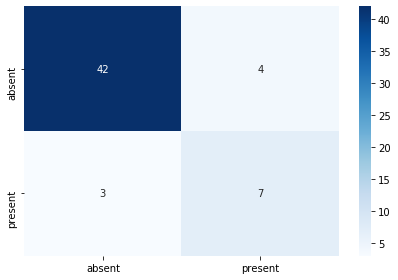


Test confusion matrix


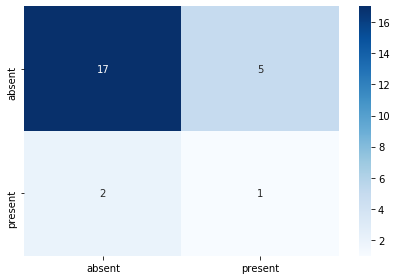

In [199]:
from lightgbm import LGBMClassifier

# instantiate
LGBM_model = LGBMClassifier(random_state = 1)

# model training
LGBM_model.fit(X_train, y_train)

### model prediction
y_test_pred = LGBM_model.predict(X_test)
y_train_pred = LGBM_model.predict(X_train)

### model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# show the confusion matrix
print(f'The confusion matrix for testing data: \n{confusion_matrix(y_test, y_test_pred)}')
# Show a classfication report for the test data result
# In this example, absent is the positive and presence is the negative
print(f'\nThe classification report for testing data: \n{classification_report(y_test,y_test_pred)}')

# Show a classfication report for the train data result
print(f'\nThe classification report for training data: \n{classification_report(y_train,y_train_pred)}')

# Show the feature importance
print(f'\nThe feature importance: {LGBM_model.feature_importances_}')
      
# function to plot a fansier confusion matrix
classes = ['absent','present']
def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'\n{dom} confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
                ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()
    
print(f'\nTrain score: {accuracy_score(y_train_pred,y_train)}')
print(f'Test score: {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

In [200]:
# Hyperparamter tuning by Optuna
import time
import sklearn
import optuna

# define the machine learning logic and return the evaluation score here  
def LGBM_objective(trial):

#     df = pd.read_csv("M3L5/kyphosis.csv")
#     df["Age"]/=12
#     X = df.drop("Kyphosis", axis = 1)
#     y = df["Kyphosis"]
#     X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

    classifier_name = trial.suggest_categorical("classifier", ["LGBM"])
    if classifier_name == "LGBM":
        # The suggested parameter for tuning
        LGBM_n_estimators = trial.suggest_int("LGBM_n_estimators", 1, 201, step = 10)
        LGBM_learning_rate = trial.suggest_categorical("LGBM_learning_rate", [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2])
        LGBM_min_child_weight = trial.suggest_int("LGBM_min_child_weight", 1, 4, step = 1)
        LGBM_subsample = trial.suggest_float("LGBM_subsample", 0.1, 1, step = 0.1)
        # LGBM_colsample_bytree = trial.suggest_float("LGBM_colsample_bytree", 0.1, 1, step = 0.1)
        LGBM_max_depth = trial.suggest_int("LGBM_max_depth", 1, 6, step = 1)
                # rf_oob_score = trial.suggest_categorical("rf_oob_score", [True, False])
        classifier_obj = LGBMClassifier(
            n_estimators = LGBM_n_estimators, 
            learning_rate = LGBM_learning_rate,
            min_child_weight = LGBM_min_child_weight,
            subsample = LGBM_subsample,
            # colsample_bytree = LGBM_colsample_bytree,
            max_depth = LGBM_max_depth,
            # oob_score = rf_oob_score,
            random_state=1
        )

    score = sklearn.model_selection.cross_val_score(classifier_obj, X_test, y_test, n_jobs=-1, cv=4)
    accuracy = score.mean()
    return accuracy

start = time.time()
if __name__ == "__main__":
    # Create Study object
    LGBM_study = optuna.create_study(direction="maximize")
    # Optimize the study, use more trials to obtain better result, use less trials to be more cost-efficient
    LGBM_study.optimize(LGBM_objective, n_trials=100)
    # Print the result
    print(f"Best score: {LGBM_study.best_value:0.4f}\n") # Return the best objective value in the study
    print(f"Optimized parameters: {LGBM_study.best_params}\n")
    print(f"Best trial: {LGBM_study.best_trial}\n")
end = time.time()
LGBM_time = end-start
print(f"Elapsed time: {LGBM_time:0.2f} seconds")

[I 2022-03-31 14:21:37,747] A new study created in memory with name: no-name-9a9017d0-f7a2-40c8-91ba-a324c6eda137
[I 2022-03-31 14:21:39,127] Trial 0 finished with value: 0.7619047619047619 and parameters: {'classifier': 'LGBM', 'LGBM_n_estimators': 161, 'LGBM_learning_rate': 0.5, 'LGBM_min_child_weight': 2, 'LGBM_subsample': 0.30000000000000004, 'LGBM_max_depth': 4}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-31 14:21:39,259] Trial 1 finished with value: 0.7619047619047619 and parameters: {'classifier': 'LGBM', 'LGBM_n_estimators': 201, 'LGBM_learning_rate': 1, 'LGBM_min_child_weight': 2, 'LGBM_subsample': 0.9, 'LGBM_max_depth': 3}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-31 14:21:39,368] Trial 2 finished with value: 0.7619047619047619 and parameters: {'classifier': 'LGBM', 'LGBM_n_estimators': 51, 'LGBM_learning_rate': 1, 'LGBM_min_child_weight': 2, 'LGBM_subsample': 0.2, 'LGBM_max_depth': 1}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-

[I 2022-03-31 14:21:42,603] Trial 27 finished with value: 0.7619047619047619 and parameters: {'classifier': 'LGBM', 'LGBM_n_estimators': 11, 'LGBM_learning_rate': 0.1, 'LGBM_min_child_weight': 4, 'LGBM_subsample': 0.30000000000000004, 'LGBM_max_depth': 6}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-31 14:21:42,725] Trial 28 finished with value: 0.7619047619047619 and parameters: {'classifier': 'LGBM', 'LGBM_n_estimators': 31, 'LGBM_learning_rate': 0.0001, 'LGBM_min_child_weight': 4, 'LGBM_subsample': 0.2, 'LGBM_max_depth': 5}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-31 14:21:42,860] Trial 29 finished with value: 0.7619047619047619 and parameters: {'classifier': 'LGBM', 'LGBM_n_estimators': 121, 'LGBM_learning_rate': 0.0001, 'LGBM_min_child_weight': 3, 'LGBM_subsample': 0.4, 'LGBM_max_depth': 5}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-31 14:21:42,981] Trial 30 finished with value: 0.7619047619047619 and parameters: {'classifier': 'L

[I 2022-03-31 14:21:46,064] Trial 54 finished with value: 0.7619047619047619 and parameters: {'classifier': 'LGBM', 'LGBM_n_estimators': 21, 'LGBM_learning_rate': 0.5, 'LGBM_min_child_weight': 4, 'LGBM_subsample': 0.2, 'LGBM_max_depth': 6}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-31 14:21:46,194] Trial 55 finished with value: 0.7619047619047619 and parameters: {'classifier': 'LGBM', 'LGBM_n_estimators': 51, 'LGBM_learning_rate': 0.5, 'LGBM_min_child_weight': 4, 'LGBM_subsample': 0.1, 'LGBM_max_depth': 5}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-31 14:21:46,316] Trial 56 finished with value: 0.7619047619047619 and parameters: {'classifier': 'LGBM', 'LGBM_n_estimators': 1, 'LGBM_learning_rate': 0.5, 'LGBM_min_child_weight': 4, 'LGBM_subsample': 0.2, 'LGBM_max_depth': 3}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-31 14:21:46,440] Trial 57 finished with value: 0.7619047619047619 and parameters: {'classifier': 'LGBM', 'LGBM_n_estimators

[I 2022-03-31 14:21:49,675] Trial 81 finished with value: 0.7619047619047619 and parameters: {'classifier': 'LGBM', 'LGBM_n_estimators': 41, 'LGBM_learning_rate': 0.5, 'LGBM_min_child_weight': 4, 'LGBM_subsample': 0.2, 'LGBM_max_depth': 3}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-31 14:21:49,809] Trial 82 finished with value: 0.7619047619047619 and parameters: {'classifier': 'LGBM', 'LGBM_n_estimators': 51, 'LGBM_learning_rate': 0.5, 'LGBM_min_child_weight': 4, 'LGBM_subsample': 0.9, 'LGBM_max_depth': 3}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-31 14:21:49,941] Trial 83 finished with value: 0.7619047619047619 and parameters: {'classifier': 'LGBM', 'LGBM_n_estimators': 41, 'LGBM_learning_rate': 1, 'LGBM_min_child_weight': 2, 'LGBM_subsample': 0.9, 'LGBM_max_depth': 3}. Best is trial 0 with value: 0.7619047619047619.
[I 2022-03-31 14:21:50,074] Trial 84 finished with value: 0.7619047619047619 and parameters: {'classifier': 'LGBM', 'LGBM_n_estimators'

Best score: 0.7619

Optimized parameters: {'classifier': 'LGBM', 'LGBM_n_estimators': 161, 'LGBM_learning_rate': 0.5, 'LGBM_min_child_weight': 2, 'LGBM_subsample': 0.30000000000000004, 'LGBM_max_depth': 4}

Best trial: FrozenTrial(number=0, values=[0.7619047619047619], datetime_start=datetime.datetime(2022, 3, 31, 14, 21, 37, 755890), datetime_complete=datetime.datetime(2022, 3, 31, 14, 21, 39, 125059), params={'classifier': 'LGBM', 'LGBM_n_estimators': 161, 'LGBM_learning_rate': 0.5, 'LGBM_min_child_weight': 2, 'LGBM_subsample': 0.30000000000000004, 'LGBM_max_depth': 4}, distributions={'classifier': CategoricalDistribution(choices=('LGBM',)), 'LGBM_n_estimators': IntUniformDistribution(high=201, low=1, step=10), 'LGBM_learning_rate': CategoricalDistribution(choices=(0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2)), 'LGBM_min_child_weight': IntUniformDistribution(high=4, low=1, step=1), 'LGBM_subsample': DiscreteUniformDistribution(high=1.0, low=0.1, q=0.1), 'LGBM_max_depth': IntUniformDistributi

In [201]:
# store all the params if they receive the same score as that of the best score
LGBM_best_params = best_result_df(LGBM_study)
# for i in LGBM_best_params:
#     print(i.values())
print(f'The total number of hyperparameter combinations that output the best value: {len(LGBM_best_params)}')

The total number of hyperparameter combinations that output the best value: 100


### The tuned LightGMB model improves the test data model accuracy from 72% to 76%.

In [202]:
performance_df['LightGBM'] = [round(LGBM_study.best_value,4), LGBM_study.best_params, np.round(LGBM_time,2), "n_estimators, learning_rate, min_child_weight, subsample, max_depth", len(LGBM_best_params)]
performance_df

,AdaBoost,Gradient Boost,XGBoost,LightGBM,CatBoost
Best score,0.6786,0.7619,0.7619,0.7619,0.7619
Optimized parameter,"{'classifier': 'AdaBoost', 'AdaBoost_n_estimators': 21, 'AdaBoost_max_depth': 4, 'AdaBoost_learning_rate': 0.0001}","{'classifier': 'GradientBoost', 'GradientBoost_n_estimators': 56, 'GradientBoost_learning_rate': 0.0001, 'GradientBoost_max_features': 'sqrt', 'GradientBoost_max_depth': 2}","{'classifier': 'XGBoost', 'XGBoost_n_estimators': 11, 'XGBoost_learning_rate': 0.001, 'XGBoost_min_child_weight': 3, 'XGBoost_subsample': 0.30000000000000004, 'XGBoost_max_depth': 6}","{'classifier': 'LGBM', 'LGBM_n_estimators': 161, 'LGBM_learning_rate': 0.5, 'LGBM_min_child_weight': 2, 'LGBM_subsample': 0.30000000000000004, 'LGBM_max_depth': 4}","{'classifier': 'CatBoost', 'CatBoost_iterations': 70, 'CatBoost_depth': 3, 'CatBoost_learning_rate': 0.0051219695839539005, 'CatBoost_random_strength': 9.762918220330207, 'CatBoost_border_count': 1}"
Computed time,32.22,20.93,31.75,14.49,27.5
Hyperparameters,"n_estimators, base_estimator, learning_rate","n_estimators, learning_rate, max_features, max_depth","n_estimators, learning_rate, min_child_weight, subsample, max_depth","n_estimators, learning_rate, min_child_weight, subsample, max_depth","iterations, depth, learning_rate, random_strength, border_count"
No. of Optimized Params giving the Best score,43,74,96,100,58


# 5. CatBoost

Learning rate set to 0.003009
0:	learn: 0.6906219	total: 6.05ms	remaining: 6.04s
1:	learn: 0.6877362	total: 7.53ms	remaining: 3.75s
2:	learn: 0.6848824	total: 9.13ms	remaining: 3.04s
3:	learn: 0.6820525	total: 10.7ms	remaining: 2.68s
4:	learn: 0.6793868	total: 12.4ms	remaining: 2.46s
5:	learn: 0.6764067	total: 13.7ms	remaining: 2.27s
6:	learn: 0.6734220	total: 15.9ms	remaining: 2.25s
7:	learn: 0.6704701	total: 18.1ms	remaining: 2.24s
8:	learn: 0.6671618	total: 19.7ms	remaining: 2.17s
9:	learn: 0.6649312	total: 21.7ms	remaining: 2.15s
10:	learn: 0.6627865	total: 23.5ms	remaining: 2.11s
11:	learn: 0.6600144	total: 27.3ms	remaining: 2.25s
12:	learn: 0.6566547	total: 29.8ms	remaining: 2.26s
13:	learn: 0.6535081	total: 31.9ms	remaining: 2.24s
14:	learn: 0.6510716	total: 34.1ms	remaining: 2.24s
15:	learn: 0.6486849	total: 36.2ms	remaining: 2.23s
16:	learn: 0.6459381	total: 38.4ms	remaining: 2.22s
17:	learn: 0.6423679	total: 40ms	remaining: 2.18s
18:	learn: 0.6396751	total: 42ms	remaining: 2.

210:	learn: 0.3450771	total: 390ms	remaining: 1.46s
211:	learn: 0.3441890	total: 392ms	remaining: 1.46s
212:	learn: 0.3434140	total: 394ms	remaining: 1.46s
213:	learn: 0.3424801	total: 396ms	remaining: 1.45s
214:	learn: 0.3414350	total: 398ms	remaining: 1.45s
215:	learn: 0.3404741	total: 400ms	remaining: 1.45s
216:	learn: 0.3394940	total: 401ms	remaining: 1.45s
217:	learn: 0.3383919	total: 403ms	remaining: 1.45s
218:	learn: 0.3377582	total: 405ms	remaining: 1.44s
219:	learn: 0.3369642	total: 406ms	remaining: 1.44s
220:	learn: 0.3362869	total: 408ms	remaining: 1.44s
221:	learn: 0.3356800	total: 410ms	remaining: 1.44s
222:	learn: 0.3349253	total: 411ms	remaining: 1.43s
223:	learn: 0.3340205	total: 413ms	remaining: 1.43s
224:	learn: 0.3334773	total: 414ms	remaining: 1.43s
225:	learn: 0.3326925	total: 416ms	remaining: 1.42s
226:	learn: 0.3320027	total: 417ms	remaining: 1.42s
227:	learn: 0.3313318	total: 419ms	remaining: 1.42s
228:	learn: 0.3306054	total: 421ms	remaining: 1.42s
229:	learn: 

423:	learn: 0.2224076	total: 796ms	remaining: 1.08s
424:	learn: 0.2221394	total: 798ms	remaining: 1.08s
425:	learn: 0.2218086	total: 800ms	remaining: 1.08s
426:	learn: 0.2213783	total: 802ms	remaining: 1.08s
427:	learn: 0.2211236	total: 804ms	remaining: 1.07s
428:	learn: 0.2207164	total: 806ms	remaining: 1.07s
429:	learn: 0.2205169	total: 808ms	remaining: 1.07s
430:	learn: 0.2199304	total: 809ms	remaining: 1.07s
431:	learn: 0.2195259	total: 811ms	remaining: 1.07s
432:	learn: 0.2192285	total: 813ms	remaining: 1.06s
433:	learn: 0.2187139	total: 814ms	remaining: 1.06s
434:	learn: 0.2183082	total: 816ms	remaining: 1.06s
435:	learn: 0.2180208	total: 818ms	remaining: 1.06s
436:	learn: 0.2176963	total: 819ms	remaining: 1.05s
437:	learn: 0.2174788	total: 821ms	remaining: 1.05s
438:	learn: 0.2170826	total: 822ms	remaining: 1.05s
439:	learn: 0.2168015	total: 824ms	remaining: 1.05s
440:	learn: 0.2163885	total: 826ms	remaining: 1.05s
441:	learn: 0.2160914	total: 828ms	remaining: 1.04s
442:	learn: 

640:	learn: 0.1589916	total: 1.2s	remaining: 671ms
641:	learn: 0.1588338	total: 1.2s	remaining: 669ms
642:	learn: 0.1586185	total: 1.2s	remaining: 668ms
643:	learn: 0.1583931	total: 1.2s	remaining: 666ms
644:	learn: 0.1581928	total: 1.21s	remaining: 664ms
645:	learn: 0.1579650	total: 1.21s	remaining: 662ms
646:	learn: 0.1577477	total: 1.21s	remaining: 660ms
647:	learn: 0.1574474	total: 1.21s	remaining: 658ms
648:	learn: 0.1571813	total: 1.21s	remaining: 656ms
649:	learn: 0.1569899	total: 1.22s	remaining: 655ms
650:	learn: 0.1568095	total: 1.22s	remaining: 653ms
651:	learn: 0.1565746	total: 1.22s	remaining: 651ms
652:	learn: 0.1563564	total: 1.22s	remaining: 649ms
653:	learn: 0.1561630	total: 1.22s	remaining: 647ms
654:	learn: 0.1560137	total: 1.22s	remaining: 645ms
655:	learn: 0.1558607	total: 1.23s	remaining: 643ms
656:	learn: 0.1556735	total: 1.23s	remaining: 641ms
657:	learn: 0.1556017	total: 1.23s	remaining: 639ms
658:	learn: 0.1554513	total: 1.23s	remaining: 637ms
659:	learn: 0.15

858:	learn: 0.1194540	total: 1.6s	remaining: 263ms
859:	learn: 0.1193388	total: 1.6s	remaining: 261ms
860:	learn: 0.1191858	total: 1.61s	remaining: 259ms
861:	learn: 0.1190538	total: 1.61s	remaining: 257ms
862:	learn: 0.1189309	total: 1.61s	remaining: 256ms
863:	learn: 0.1187588	total: 1.61s	remaining: 254ms
864:	learn: 0.1186714	total: 1.61s	remaining: 252ms
865:	learn: 0.1185049	total: 1.61s	remaining: 250ms
866:	learn: 0.1183715	total: 1.62s	remaining: 248ms
867:	learn: 0.1182503	total: 1.62s	remaining: 246ms
868:	learn: 0.1180896	total: 1.62s	remaining: 244ms
869:	learn: 0.1178542	total: 1.62s	remaining: 243ms
870:	learn: 0.1177530	total: 1.62s	remaining: 241ms
871:	learn: 0.1176098	total: 1.63s	remaining: 239ms
872:	learn: 0.1174843	total: 1.63s	remaining: 237ms
873:	learn: 0.1173739	total: 1.63s	remaining: 235ms
874:	learn: 0.1172220	total: 1.63s	remaining: 233ms
875:	learn: 0.1170636	total: 1.63s	remaining: 231ms
876:	learn: 0.1169458	total: 1.64s	remaining: 229ms
877:	learn: 0.

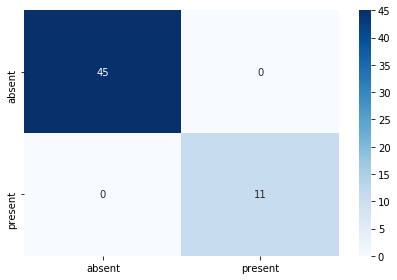


Test confusion matrix


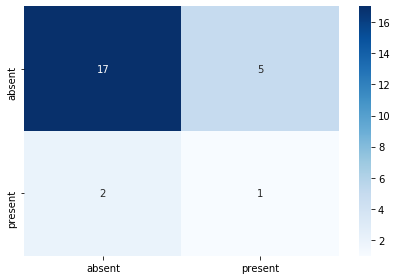

In [203]:
from catboost import CatBoostClassifier

# instantiate
CatBoost_model = CatBoostClassifier(random_state = 1)

# model training
CatBoost_model.fit(X_train, y_train)

### model prediction
y_test_pred = CatBoost_model.predict(X_test)
y_train_pred = CatBoost_model.predict(X_train)

### model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# show the confusion matrix
print(f'The confusion matrix for testing data: \n{confusion_matrix(y_test, y_test_pred)}')
# Show a classfication report for the test data result
# In this example, absent is the positive and presence is the negative
print(f'\nThe classification report for testing data: \n{classification_report(y_test,y_test_pred)}')

# Show a classfication report for the train data result
print(f'\nThe classification report for training data: \n{classification_report(y_train,y_train_pred)}')

# Show the feature importance
print(f'\nThe feature importance: {CatBoost_model.feature_importances_}')
      
# function to plot a fansier confusion matrix
classes = ['absent','present']
def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'\n{dom} confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
                ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()
    
print(f'\nTrain score: {accuracy_score(y_train_pred,y_train)}')
print(f'Test score: {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

In [204]:
# Hyperparamter tuning by Optuna
import time
import sklearn
import optuna

# define the machine learning logic and return the evaluation score here  
def CatBoost_objective(trial):

#     df = pd.read_csv("M3L5/kyphosis.csv")
#     df["Age"]/=12
#     X = df.drop("Kyphosis", axis = 1)
#     y = df["Kyphosis"]
#     X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

    classifier_name = trial.suggest_categorical("classifier", ["CatBoost"])
    if classifier_name == "CatBoost":
        # The suggested parameter for tuning
        CatBoost_iterations = trial.suggest_int("CatBoost_iterations", 10, 100, step = 10)
        CatBoost_depth = trial.suggest_int("CatBoost_depth", 1, 6, step = 1)
        CatBoost_learning_rate = trial.suggest_loguniform("CatBoost_learning_rate", 0.0001, 2)
        CatBoost_random_strength = trial.suggest_loguniform("CatBoost_random_strength", 0.0001, 10)
        CatBoost_border_count = trial.suggest_int("CatBoost_border_count", 1, 201, step = 10)
        # CatBoost_l2_leaf_reg = trial.suggest_float("CatBoost_l2_leaf_reg", 2, 30, step = 0.1)
        # CatBoost_scale_pos_weight = trial.suggest_uniform("CatBoost_scale_pos_weight", 0.01, 1)

                # rf_oob_score = trial.suggest_categorical("rf_oob_score", [True, False])
        classifier_obj = CatBoostClassifier(
            iterations = CatBoost_iterations,
            depth = CatBoost_depth,
            learning_rate = CatBoost_learning_rate,
            random_strength = CatBoost_random_strength,
            border_count = CatBoost_border_count,
            # l2_leaf_reg = CatBoost_l2_leaf_reg,
            # scale_pos_weight = CatBoost_scale_pos_weight,
            random_state=1
        )

    score = sklearn.model_selection.cross_val_score(classifier_obj, X_test, y_test, n_jobs=-1, cv=4)
    accuracy = score.mean()
    return accuracy

start = time.time()
if __name__ == "__main__":
    # Create Study object
    CatBoost_study = optuna.create_study(direction="maximize")
    # Optimize the study, use more trials to obtain better result, use less trials to be more cost-efficient
    CatBoost_study.optimize(CatBoost_objective, n_trials=100)
    # Print the result
    print(f"Best score: {CatBoost_study.best_value:0.4f}\n") # Return the best objective value in the study
    print(f"Optimized parameters: {CatBoost_study.best_params}\n")
    print(f"Best trial: {CatBoost_study.best_trial}\n")
end = time.time()
CatBoost_time = end-start
print(f"Elapsed time: {CatBoost_time:0.2f} seconds")

[I 2022-03-31 14:22:02,004] A new study created in memory with name: no-name-ae406074-bd26-4ea1-b492-ec1d67a443fc
[I 2022-03-31 14:22:05,011] Trial 0 finished with value: 0.5535714285714286 and parameters: {'classifier': 'CatBoost', 'CatBoost_iterations': 70, 'CatBoost_depth': 4, 'CatBoost_learning_rate': 0.28681903688528265, 'CatBoost_random_strength': 0.0022969693542030734, 'CatBoost_border_count': 101}. Best is trial 0 with value: 0.5535714285714286.
[I 2022-03-31 14:22:05,183] Trial 1 finished with value: 0.7619047619047619 and parameters: {'classifier': 'CatBoost', 'CatBoost_iterations': 40, 'CatBoost_depth': 3, 'CatBoost_learning_rate': 0.00273605508082631, 'CatBoost_random_strength': 2.9339693845357684, 'CatBoost_border_count': 71}. Best is trial 1 with value: 0.7619047619047619.
[I 2022-03-31 14:22:05,361] Trial 2 finished with value: 0.5952380952380952 and parameters: {'classifier': 'CatBoost', 'CatBoost_iterations': 50, 'CatBoost_depth': 4, 'CatBoost_learning_rate': 0.0029925

[I 2022-03-31 14:22:09,252] Trial 23 finished with value: 0.7619047619047619 and parameters: {'classifier': 'CatBoost', 'CatBoost_iterations': 30, 'CatBoost_depth': 1, 'CatBoost_learning_rate': 0.0016343513260572557, 'CatBoost_random_strength': 0.6499077996255368, 'CatBoost_border_count': 131}. Best is trial 1 with value: 0.7619047619047619.
[I 2022-03-31 14:22:09,404] Trial 24 finished with value: 0.7202380952380952 and parameters: {'classifier': 'CatBoost', 'CatBoost_iterations': 20, 'CatBoost_depth': 2, 'CatBoost_learning_rate': 0.00024408451863138422, 'CatBoost_random_strength': 0.24224123323739252, 'CatBoost_border_count': 91}. Best is trial 1 with value: 0.7619047619047619.
[I 2022-03-31 14:22:09,567] Trial 25 finished with value: 0.7619047619047619 and parameters: {'classifier': 'CatBoost', 'CatBoost_iterations': 20, 'CatBoost_depth': 3, 'CatBoost_learning_rate': 0.005564451347683291, 'CatBoost_random_strength': 6.2032741251299734, 'CatBoost_border_count': 151}. Best is trial 1 

[I 2022-03-31 14:22:12,909] Trial 46 finished with value: 0.7619047619047619 and parameters: {'classifier': 'CatBoost', 'CatBoost_iterations': 20, 'CatBoost_depth': 1, 'CatBoost_learning_rate': 0.0004978223236245848, 'CatBoost_random_strength': 7.83289365735024, 'CatBoost_border_count': 41}. Best is trial 1 with value: 0.7619047619047619.
[I 2022-03-31 14:22:13,073] Trial 47 finished with value: 0.6785714285714286 and parameters: {'classifier': 'CatBoost', 'CatBoost_iterations': 30, 'CatBoost_depth': 3, 'CatBoost_learning_rate': 0.0016799044248143368, 'CatBoost_random_strength': 0.6252063880671401, 'CatBoost_border_count': 141}. Best is trial 1 with value: 0.7619047619047619.
[I 2022-03-31 14:22:13,247] Trial 48 finished with value: 0.7619047619047619 and parameters: {'classifier': 'CatBoost', 'CatBoost_iterations': 50, 'CatBoost_depth': 1, 'CatBoost_learning_rate': 0.0012987508845578627, 'CatBoost_random_strength': 0.09273495240646591, 'CatBoost_border_count': 161}. Best is trial 1 wi

[I 2022-03-31 14:22:16,885] Trial 69 finished with value: 0.7619047619047619 and parameters: {'classifier': 'CatBoost', 'CatBoost_iterations': 40, 'CatBoost_depth': 2, 'CatBoost_learning_rate': 0.00021506458885964564, 'CatBoost_random_strength': 6.864522843179887, 'CatBoost_border_count': 21}. Best is trial 1 with value: 0.7619047619047619.
[I 2022-03-31 14:22:17,028] Trial 70 finished with value: 0.7619047619047619 and parameters: {'classifier': 'CatBoost', 'CatBoost_iterations': 20, 'CatBoost_depth': 2, 'CatBoost_learning_rate': 0.00011465893830032678, 'CatBoost_random_strength': 4.916643456673686, 'CatBoost_border_count': 111}. Best is trial 1 with value: 0.7619047619047619.
[I 2022-03-31 14:22:17,199] Trial 71 finished with value: 0.7619047619047619 and parameters: {'classifier': 'CatBoost', 'CatBoost_iterations': 50, 'CatBoost_depth': 2, 'CatBoost_learning_rate': 0.00014868607105673665, 'CatBoost_random_strength': 1.0623418499455721, 'CatBoost_border_count': 41}. Best is trial 1 w

[I 2022-03-31 14:22:21,365] Trial 93 finished with value: 0.7619047619047619 and parameters: {'classifier': 'CatBoost', 'CatBoost_iterations': 60, 'CatBoost_depth': 1, 'CatBoost_learning_rate': 0.0006122510674865473, 'CatBoost_random_strength': 7.469646802455243, 'CatBoost_border_count': 111}. Best is trial 1 with value: 0.7619047619047619.
[I 2022-03-31 14:22:21,578] Trial 94 finished with value: 0.7619047619047619 and parameters: {'classifier': 'CatBoost', 'CatBoost_iterations': 90, 'CatBoost_depth': 1, 'CatBoost_learning_rate': 0.00042140425741280646, 'CatBoost_random_strength': 7.021726076529455, 'CatBoost_border_count': 121}. Best is trial 1 with value: 0.7619047619047619.
[I 2022-03-31 14:22:21,710] Trial 95 finished with value: 0.7619047619047619 and parameters: {'classifier': 'CatBoost', 'CatBoost_iterations': 10, 'CatBoost_depth': 1, 'CatBoost_learning_rate': 0.00027306037989901133, 'CatBoost_random_strength': 3.8191105279921786, 'CatBoost_border_count': 71}. Best is trial 1 w

Best score: 0.7619

Optimized parameters: {'classifier': 'CatBoost', 'CatBoost_iterations': 40, 'CatBoost_depth': 3, 'CatBoost_learning_rate': 0.00273605508082631, 'CatBoost_random_strength': 2.9339693845357684, 'CatBoost_border_count': 71}

Best trial: FrozenTrial(number=1, values=[0.7619047619047619], datetime_start=datetime.datetime(2022, 3, 31, 14, 22, 5, 13202), datetime_complete=datetime.datetime(2022, 3, 31, 14, 22, 5, 182907), params={'classifier': 'CatBoost', 'CatBoost_iterations': 40, 'CatBoost_depth': 3, 'CatBoost_learning_rate': 0.00273605508082631, 'CatBoost_random_strength': 2.9339693845357684, 'CatBoost_border_count': 71}, distributions={'classifier': CategoricalDistribution(choices=('CatBoost',)), 'CatBoost_iterations': IntUniformDistribution(high=100, low=10, step=10), 'CatBoost_depth': IntUniformDistribution(high=6, low=1, step=1), 'CatBoost_learning_rate': LogUniformDistribution(high=2.0, low=0.0001), 'CatBoost_random_strength': LogUniformDistribution(high=10.0, low=

In [205]:
# store all the params if they receive the same score as that of the best score
CatBoost_best_params = best_result_df(CatBoost_study)
# for i in CatBoost_best_params:
#     print(i.values())
print(f'The total number of hyperparameter combinations that output the best value: {len(CatBoost_best_params)}')

The total number of hyperparameter combinations that output the best value: 71


### The tuned CatBoost model improves the test data model accuracy from 72% to 76%.

In [206]:
performance_df['CatBoost'] = [round(CatBoost_study.best_value,4), CatBoost_study.best_params, np.round(CatBoost_time,2), "iterations, depth, learning_rate, random_strength, border_count", len(CatBoost_best_params)]
performance_df

,AdaBoost,Gradient Boost,XGBoost,LightGBM,CatBoost
Best score,0.6786,0.7619,0.7619,0.7619,0.7619
Optimized parameter,"{'classifier': 'AdaBoost', 'AdaBoost_n_estimators': 21, 'AdaBoost_max_depth': 4, 'AdaBoost_learning_rate': 0.0001}","{'classifier': 'GradientBoost', 'GradientBoost_n_estimators': 56, 'GradientBoost_learning_rate': 0.0001, 'GradientBoost_max_features': 'sqrt', 'GradientBoost_max_depth': 2}","{'classifier': 'XGBoost', 'XGBoost_n_estimators': 11, 'XGBoost_learning_rate': 0.001, 'XGBoost_min_child_weight': 3, 'XGBoost_subsample': 0.30000000000000004, 'XGBoost_max_depth': 6}","{'classifier': 'LGBM', 'LGBM_n_estimators': 161, 'LGBM_learning_rate': 0.5, 'LGBM_min_child_weight': 2, 'LGBM_subsample': 0.30000000000000004, 'LGBM_max_depth': 4}","{'classifier': 'CatBoost', 'CatBoost_iterations': 40, 'CatBoost_depth': 3, 'CatBoost_learning_rate': 0.00273605508082631, 'CatBoost_random_strength': 2.9339693845357684, 'CatBoost_border_count': 71}"
Computed time,32.22,20.93,31.75,14.49,20.39
Hyperparameters,"n_estimators, base_estimator, learning_rate","n_estimators, learning_rate, max_features, max_depth","n_estimators, learning_rate, min_child_weight, subsample, max_depth","n_estimators, learning_rate, min_child_weight, subsample, max_depth","iterations, depth, learning_rate, random_strength, border_count"
No. of Optimized Params giving the Best score,43,74,96,100,71
